# MLP with Looking Days Ahead Predictions and Language Segmentation

#### This notebook took MLP and tested for up to five days ahead predictions, as well as segmenting by the top 5 languages for said predictions

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import dateutil.parser as parser
from datetime import datetime, date, timedelta
import torch
import skorch
import scipy
import torch.nn as nn
import torch
import torch.nn.functional as F
import sys
from skorch.helper import DataFrameTransformer
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from skorch.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from skorch import NeuralNetRegressor
import pickle
import emoji
def identity_tokenizer(text):
    return text
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)

In [2]:
merged = pd.read_csv('mergedfullwithmoredates.csv')
from sklearn.model_selection import train_test_split  
# mergedbig, mergedsmall = train_test_split(merged, test_size=0.15, random_state=0)
# # mergedsmall.to_csv("mergedsmall.csv", index = False)
# # mergedsmall = pd.read_csv('mergedsmall.csv')
# merged = mergedsmall
merged = merged.dropna(subset=['Change1','Change2','Change3','Change4','Change5'])
merged = merged.reset_index(drop=True)
# Obtaining the tweet contents into a list
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer

merged

,text,referenced_tweets,id,lang,Date,time,usedate,usedate1,usedate2,usedate3,...,Volume,Open,High,Low,Change,Change1,Change2,Change3,Change4,Change5
0,#computer #technology #pc #tech #gaming #lapto...,1.389731e+18,1389731436152987650,und,2021-05-04,23:59:28,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
1,Super Game Talk Video Alpha! https://t.co/BgG3...,1.389727e+18,1389731281525686273,en,2021-05-04,23:58:52,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
2,Nailed the interview #apple https://t.co/QIXRf...,1.389730e+18,1389731277427908615,en,2021-05-04,23:58:51,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
3,Apple、macOS Big Sur 11.4ベータ2をリリース #Apple #ベータ ...,1.389731e+18,1389731204866269184,ja,2021-05-04,23:58:33,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
4,iPhone13 Pro MaxのCADデータを基にしたモックアップ〜ノッチが小型化 #Ap...,1.389657e+18,1389730808034861056,ja,2021-05-04,23:56:59,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342219,"Download JOBIN THE PENGUIN! Awesome, retro-ins...",NaN,1259996823118319621,en,2020-05-12,00:00:26,2020-05-12,2020-05-13,2020-05-14,2020-05-15,...,162301040.0,79.4575,79.9220,77.7275,-1.605,-1.125,1.2575,1.84,0.4475,-0.4725
3342220,"2019 13"" 1.6GHz/128GB #Apple #MacBook Airs, re...",NaN,1259996818450132993,en,2020-05-12,00:00:25,2020-05-12,2020-05-13,2020-05-14,2020-05-15,...,162301040.0,79.4575,79.9220,77.7275,-1.605,-1.125,1.2575,1.84,0.4475,-0.4725
3342221,How to use Apple Maps mobility trends data htt...,NaN,1259996729451085827,en,2020-05-12,00:00:04,2020-05-12,2020-05-13,2020-05-14,2020-05-15,...,162301040.0,79.4575,79.9220,77.7275,-1.605,-1.125,1.2575,1.84,0.4475,-0.4725
3342222,AirPods Studio Could Come With Head And Neck D...,NaN,1259996725638504448,en,2020-05-12,00:00:03,2020-05-12,2020-05-13,2020-05-14,2020-05-15,...,162301040.0,79.4575,79.9220,77.7275,-1.605,-1.125,1.2575,1.84,0.4475,-0.4725


In [26]:
print(merged.isna().sum())

text                      0
referenced_tweets    200519
id                        0
lang                      0
Date                      0
time                      0
usedate                   0
usedate1                  0
usedate2                  0
usedate3                  0
usedate4                  0
usedate5                  0
Close/Last                0
Volume                    0
Open                      0
High                      0
Low                       0
Change                    0
Change1                   0
Change2                   0
Change3                   0
Change4                   0
Change5                   0
dtype: int64


In [3]:
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    
    
    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))
    # Replace all emojis with text
    processed_tweet = emoji.demojize(processed_tweet)
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    
#     processed_tweet = re.sub(r'http\S+', '', processed_tweet)
    
    
#     processed_tweet = re.sub(r'co\S+', '', processed_tweet) 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
#     processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    

    
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweet = lemming(processed_tweet)
    
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)

In [8]:
print(len(processed_tweets))

3342224


In [6]:
y = merged[['Change','Change1','Change2','Change3','Change4','Change5','usedate','usedate1','usedate2','usedate3','usedate4','usedate5']]
# X = df3
# X = df2
# X = df2array
X = processed_tweets
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

with open("x_train_ah.txt", "wb") as fp:   #Pickling
    pickle.dump(x_train, fp)
y_train.to_csv('y_train_ah.csv', index=False)
with open("x_test_ah.txt", "wb") as fp:   #Pickling
    pickle.dump(x_test, fp)
y_test.to_csv('y_test_ah.csv', index=False)

In [3]:
with open("x_train_ah.txt", "rb") as fp:   # Unpickling
    x_train = pickle.load(fp)
y_train = pd.read_csv("y_train_ah.csv")
with open("x_test_ah.txt", "rb") as fp:   # Unpickling
    x_test = pickle.load(fp)
y_test = pd.read_csv("y_test_ah.csv")

with open("X_ah.txt", "rb") as fp:   # Unpickling
    X_initial = pickle.load(fp)

In [8]:
# Predictions for MLP looking ahead using all languages
rmselist_train = []
rmselist_test = []
rmselist_holdout = []
lists = ['Change','Change1','Change2','Change3','Change4','Change5']
for pred in range(len(lists)):
    print(lists[pred])
    y_train2 = y_train.iloc[:,pred]
    y_test2 = y_test.iloc[:,pred]
    y_holdout2 = y_holdout.iloc[:,pred]

    y_train2 = y_train2.values.reshape(-1,1)
    y_test2 = y_test2.values.reshape(-1,1)
    y_holdout2 = y_holdout2.values.reshape(-1,1)
    
    y_train2 = y_train2.astype(np.float32)
    y_test2 = y_test2.astype(np.float32)
    y_holdout2 = y_holdout2.astype(np.float32)
    in_dimension = 7665
    hid_dimension = 160
    out_dimension = 1


    class PoleNN(nn.Module):
        def __init__(self):
            super(PoleNN, self).__init__()
            self.fc1 = nn.Linear(in_dimension,hid_dimension)
            self.fc2 = nn.Linear(hid_dimension,out_dimension)
            self.sigmoid = torch.nn.Sigmoid()

        def forward(self, X):
            hidden = self.fc1(X)
            hidden = self.sigmoid(hidden)
            output = self.fc2(hidden)
            return output

    from skorch import NeuralNetRegressor
    from sklearn.pipeline import Pipeline
    x_trainshape = 7665
    class RegressorModule(nn.Module):
        def __init__(
                self,
                num_units=160,
                nonlin=F.relu,
        ):
            super(RegressorModule, self).__init__()
            self.num_units = num_units
            self.nonlin = nonlin

            self.dense0 = nn.Linear(x_trainshape, num_units)
            self.nonlin = nonlin
            self.dense1 = nn.Linear(num_units, 160)
            self.output = nn.Linear(160, 1)

        def forward(self, X, **kwargs):
            X = self.nonlin(self.dense0(X))
            X = F.relu(self.dense1(X))
            X = self.output(X)
            return X

    pole_model = RegressorModule()
    optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
    net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
    def typechange(x):
        return x.astype(dtype = np.float32)
    typetransform = FunctionTransformer(typechange)

    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


    pipe.fit(X=x_train, y=y_train2)

    
    y_pred2 = pipe.predict(x_train)
    rmse = mean_squared_error(y_train2, y_pred2, squared = False)
    print('Training RMSE:', rmse)
    rmselist_train.append(rmse)
    
    y_pred = pipe.predict(x_test)
    rmse = mean_squared_error(y_test2, y_pred, squared = False)
    print('Test RMSE:', rmse)
    rmselist_test.append(rmse)
    
    y_pred = pipe.predict(x_holdout)
    rmse = mean_squared_error(y_holdout2, y_pred, squared = False)
    print('Holdout RMSE:', rmse)
    rmselist_holdout.append(rmse)
    
    print()

Change
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.0805        4.0094  987.3976
      2        3.9404        3.9333  1098.9708
      3        3.8909        3.8937  1091.2683
      4        3.8583        3.8778  1102.0815
      5        3.8316        3.8674  1102.8322
      6        3.8076        3.8488  1103.1074
      7        3.7858        3.8286  1130.3347
      8        3.7652        3.8204  1110.8287
      9        3.7455        3.8101  1133.0235
     10        3.7267        3.8012  1109.4276
     11        3.7087        3.7912  1112.7765
     12        3.6916        3.7846  1110.6702
     13        3.6746        3.7728  1112.1945
     14        3.6590        3.7675  1112.8821
     15        3.6439        3.7563  1111.6835
     16        3.6296        3.7454  1113.2609
     17        3.6163        3.7297  1111.9564
     18        3.6039        3.7300  1114.9483
     19        3.5922        3.7248  1113.1617
     20  

[Text(0.5, 0, 'Days Ahead Modelled'),
 Text(0, 0.5, 'RMSE'),
 Text(0.5, 1.0, 'Days Ahead Modelled Against RMSE')]

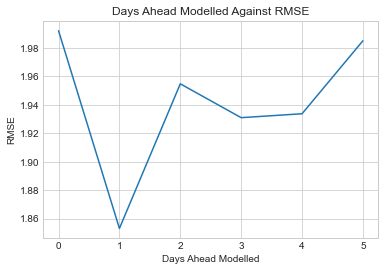

In [43]:
changelist = [1.9920682,1.8530582,1.9547465,1.9309403,1.9336934,1.9850181]
namelist = [0,1,2,3,4,5]
plt.style.use('seaborn-whitegrid')
ax = sns.lineplot(x=namelist,y=changelist)
ax.set(xlabel='Days Ahead Modelled',ylabel='RMSE',title='Days Ahead Modelled Against RMSE')

In [14]:
# Predictions iterating through the top 5 languages
rmselist_train = []
rmselist_test = []
rmselist_holdout = []
langlist = ['en','ja','ko','es','fr']
lists = ['Change','Change1','Change2','Change3','Change4','Change5']
for lang in langlist:
    
    print(lang)
    y = merged[['Change','Change1','Change2','Change3','Change4','Change5']].loc[merged['lang'] == lang]
    index = merged.index[merged['lang'] == lang].tolist()
    X = pd.DataFrame(X_initial)
    X['lang'] = merged['lang']
    X = X[0].loc[merged['lang'] == lang]
    X = X.to_list()
    from sklearn.model_selection import train_test_split  
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    
    tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')
    x_train3 = tfidf.fit_transform(x_train)
    x_test3 = tfidf.fit_transform(x_test)
    x_trainshape = x_train3.shape[1]

    optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}

    in_dimensionopt = x_trainshape

    for pred in range(len(lists)):
        print(lists[pred])
        y_train2 = y_train.iloc[:,pred]
        y_test2 = y_test.iloc[:,pred]
        y_holdout2 = y_holdout.iloc[:,pred]

        y_train2 = y_train2.values.reshape(-1,1)
        y_test2 = y_test2.values.reshape(-1,1)
        y_holdout2 = y_holdout2.values.reshape(-1,1)

        y_train2 = y_train2.astype(np.float32)
        y_test2 = y_test2.astype(np.float32)
        y_holdout2 = y_holdout2.astype(np.float32)
        in_dimension = 7665
        hid_dimension = 160
        out_dimension = 1


        class PoleNN(nn.Module):
            def __init__(self):
                super(PoleNN, self).__init__()
                self.fc1 = nn.Linear(in_dimension,hid_dimension)
                self.fc2 = nn.Linear(hid_dimension,out_dimension)
                self.sigmoid = torch.nn.Sigmoid()

            def forward(self, X):
                hidden = self.fc1(X)
                hidden = self.sigmoid(hidden)
                output = self.fc2(hidden)
                return output

        from skorch import NeuralNetRegressor
        from sklearn.pipeline import Pipeline
        class RegressorModule(nn.Module):
            def __init__(
                    self,
                    num_units=160,
                    nonlin=F.relu,
            ):
                super(RegressorModule, self).__init__()
                self.num_units = num_units
                self.nonlin = nonlin

                self.dense0 = nn.Linear(x_trainshape, num_units)
                self.nonlin = nonlin
                self.dense1 = nn.Linear(num_units, 160)
                self.output = nn.Linear(160, 1)

            def forward(self, X, **kwargs):
                X = self.nonlin(self.dense0(X))
                X = F.relu(self.dense1(X))
                X = self.output(X)
                return X

        pole_model = RegressorModule()
        net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
        def typechange(x):
            return x.astype(dtype = np.float32)
        typetransform = FunctionTransformer(typechange)

        pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


        pipe.fit(X=x_train, y=y_train2)


        y_pred2 = pipe.predict(x_train)
        rmse = mean_squared_error(y_train2, y_pred2, squared = False)
        print('Training RMSE:', rmse)
        rmselist_train.append(rmse)

        y_pred = pipe.predict(x_test)
        rmse = mean_squared_error(y_test2, y_pred, squared = False)
        print('Test RMSE:', rmse)
        rmselist_test.append(rmse)

        y_pred = pipe.predict(x_holdout)
        rmse = mean_squared_error(y_holdout2, y_pred, squared = False)
        print('Holdout RMSE:', rmse)
        rmselist_holdout.append(rmse)

        print()

en
Change
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        4.2563        4.2310  409.6601
      2        4.2200        4.1848  420.4197
      3        4.1651        4.1335  456.9538
      4        4.1263        4.1113  467.8372
      5        4.1048        4.0907  467.7580
      6        4.0902        4.0777  469.3270
      7        4.0784        4.0679  469.3939
      8        4.0677        4.0593  469.7789
      9        4.0578        4.0511  474.1020
     10        4.0477        4.0457  473.2929
     11        4.0387        4.0329  468.6881
     12        4.0284        4.0254  471.7950
     13        4.0188        4.0175  470.3104
     14        4.0094        4.0053  479.9498
     15        4.0003        4.0001  485.7686
     16        3.9913        3.9963  485.5181
     17        3.9823        3.9910  486.5030
     18        3.9738        3.9816  481.8771
     19        3.9653        3.9719  487.3005
     20        3.9579   

In [ ]:
y_train2 = y_train['Change1']
y_test2 = y_test['Change1']
y_train2 = y_train2.values.reshape(-1,1)
y_test2 = y_test2.values.reshape(-1,1)
y_train2 = y_train2.astype(np.float32)
y_test2 = y_test2.astype(np.float32)
in_dimension = 5766
hid_dimension = 10
out_dimension = 1


class PoleNN(nn.Module):
    def __init__(self):
        super(PoleNN, self).__init__()
        self.fc1 = nn.Linear(in_dimension,hid_dimension)
        self.fc2 = nn.Linear(hid_dimension,out_dimension)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        hidden = self.fc1(X)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
x_trainshape = 5766
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=200,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 200)
        self.output = nn.Linear(200, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
net = NeuralNetRegressor(module=pole_model, max_epochs=10, lr=0.1, callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train2)
y_pred = pipe.predict(x_test)
rmse = mean_squared_error(y_test2, y_pred, squared = False)
print("RMSE:", rmse)

In [38]:
modelpreds = y_pred
y = y_test2
z = y_test['usedate1']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
for uni in unique:
    predsum = 0
    reala = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            reala = real
    invested += abs(predsum)
    daychange = predsum * reala
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [34181.875]
Accuracy: 0.6234817813765182
Sum Invested: [18243.033]
Profitability: [1.8736948]


In [5]:
y_train2 = y_train['Change2']
y_test2 = y_test['Change2']
y_train2 = y_train2.values.reshape(-1,1)
y_test2 = y_test2.values.reshape(-1,1)
y_train2 = y_train2.astype(np.float32)
y_test2 = y_test2.astype(np.float32)
in_dimension = 5765
hid_dimension = 160
out_dimension = 1


class PoleNN(nn.Module):
    def __init__(self):
        super(PoleNN, self).__init__()
        self.fc1 = nn.Linear(in_dimension,hid_dimension)
        self.fc2 = nn.Linear(hid_dimension,out_dimension)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        hidden = self.fc1(X)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
x_trainshape = 7665
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=160,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 160)
        self.output = nn.Linear(160, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)\
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train2)
y_pred = pipe.predict(x_test)
rmse = mean_squared_error(y_test2, y_pred, squared = False)
print("RMSE:", rmse)
net.save_params(f_params='TwoDaysTestModelParams.pkl')


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        3.8815        3.7978  728.0657
      2        3.7746        3.7478  802.4491
      3        3.7359        3.7195  819.3978
      4        3.7082        3.7035  797.7275
      5        3.6864        3.6829  803.7463
      6        3.6667        3.6720  827.5555
      7        3.6480        3.6647  838.7983
      8        3.6295        3.6524  833.1985
      9        3.6107        3.6454  833.0687
     10        3.5923        3.6351  854.5888
     11        3.5735        3.6254  836.8775
     12        3.5563        3.6188  840.3795
     13        3.5393        3.6213  849.7071
     14        3.5237        3.6151  852.3484
     15        3.5088        3.6079  854.5699
     16        3.4946        3.6030  855.1529
     17        3.4811        3.5983  858.1309
     18        3.4687        3.5877  855.5125
     19        3.4560        3.5960  855.5598
     20        3.4447        3.588

In [14]:
print("Test Set")
modelpreds = y_pred
y = y_test2
z = y_test['usedate2']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:
    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))
print()
print("Holdout Set")
modelpreds = y_pred_holdout
y = y_holdout['Change2']
z = y_holdout_dates['usedate2']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:
    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Test Set
Profit: [1472.2698]
Accuracy: 0.5587044534412956
Sum Invested: [1054.1528]
Profitability: [1.3966379]

Holdout Set
Profit: [-65.349266]
Accuracy: 0.4444444444444444
Sum Invested: [147.59924]
Profitability: [-0.44274798]


In [5]:
changelist = ['Change1','Change3']
datelist = ['usedate1','usedate3']
for (change, date) in zip(changelist,datelist): 
    print(change)
    y_train2 = y_train[change]
    y_test2 = y_test[change]
    y_train2 = y_train2.values.reshape(-1,1)
    y_test2 = y_test2.values.reshape(-1,1)
    y_train2 = y_train2.astype(np.float32)
    y_test2 = y_test2.astype(np.float32)
    in_dimension = 5765
    hid_dimension = 160
    out_dimension = 1


    class PoleNN(nn.Module):
        def __init__(self):
            super(PoleNN, self).__init__()
            self.fc1 = nn.Linear(in_dimension,hid_dimension)
            self.fc2 = nn.Linear(hid_dimension,out_dimension)
            self.sigmoid = torch.nn.Sigmoid()

        def forward(self, X):
            hidden = self.fc1(X)
            hidden = self.sigmoid(hidden)
            output = self.fc2(hidden)
            return output

    from skorch import NeuralNetRegressor
    from sklearn.pipeline import Pipeline
    x_trainshape = 7665
    class RegressorModule(nn.Module):
        def __init__(
                self,
                num_units=160,
                nonlin=F.relu,
        ):
            super(RegressorModule, self).__init__()
            self.num_units = num_units
            self.nonlin = nonlin

            self.dense0 = nn.Linear(x_trainshape, num_units)
            self.nonlin = nonlin
            self.dense1 = nn.Linear(num_units, 160)
            self.output = nn.Linear(160, 1)

        def forward(self, X, **kwargs):
            X = self.nonlin(self.dense0(X))
            X = F.relu(self.dense1(X))
            X = self.output(X)
            return X

    pole_model = RegressorModule()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)
    optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
    net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
    def typechange(x):
        return x.astype(dtype = np.float32)
    typetransform = FunctionTransformer(typechange)\
    # pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
    # pipe = Pipeline([('net', net)])
    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


    # net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
    pipe.fit(X=x_train, y=y_train2)
    y_pred = pipe.predict(x_test)
    rmse = mean_squared_error(y_test2, y_pred, squared = False)
    print("RMSE:", rmse)
    net.save_params(f_params='OneDayTestModelParams.pkl')

    print("Test Set")
    modelpreds = y_pred
    y = y_test2
    z = y_test[date]
    unique = z.unique()
    profit = 0
    bullorbearcount = 0
    invested = 0
    predsumlist = []
    realalist = []
    for uni in unique:
        predsum = 0
        reala = 0
        predcount = 0
        for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
            if date == uni:
                predsum += pred
                predcount += 1
                reala = real
        predsum = (predsum/predcount)*14.77377722861989
        invested += abs(predsum)
        daychange = predsum * reala
        predsumlist.append(predsum)
        realalist.append(reala)
        profit += daychange
        if predsum > 0 and reala > 0:
            bullorbearcount += 1
        elif predsum < 0 and reala < 0:
            bullorbearcount += 1
    print("Profit:", profit)
    print("Accuracy:", (bullorbearcount/len(unique)))
    print("Sum Invested:", invested)
    print("Profitability:", (profit/invested))
    print()
    print("Holdout Set")
    y_pred_holdout = pipe.predict(x_holdout)
    rmse = mean_squared_error(y_holdout, y_pred_holdout, squared = False)
    modelpreds = y_pred_holdout
    y = y_holdout[change]
    z = y_holdout_dates[date]
    unique = z.unique()
    profit = 0
    bullorbearcount = 0
    invested = 0
    predsumlist = []
    realalist = []
    for uni in unique:
        predsum = 0
        reala = 0
        predcount = 0
        for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
            if date == uni:
                predsum += pred
                predcount += 1
                reala = real
        predsum = (predsum/predcount)*14.77377722861989
        invested += abs(predsum)
        daychange = predsum * reala
        predsumlist.append(predsum)
        realalist.append(reala)
        profit += daychange
        if predsum > 0 and reala > 0:
            bullorbearcount += 1
        elif predsum < 0 and reala < 0:
            bullorbearcount += 1
    print("Profit:", profit)
    print("Accuracy:", (bullorbearcount/len(unique)))
    print("Sum Invested:", invested)
    print("Profitability:", (profit/invested))

Change1
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        3.5530        3.4545  730.2780
      2        3.4171        3.3907  793.8981
      3        3.3717        3.3570  809.0089
      4        3.3458        3.3386  816.5962
      5        3.3248        3.3256  825.5430
      6        3.3061        3.3124  832.1452
      7        3.2892        3.3029  835.5547
      8        3.2732        3.2979  839.5436
      9        3.2581        3.2883  839.3219
     10        3.2436        3.2783  841.6914
     11        3.2296        3.2756  840.7294
     12        3.2157        3.2680  841.9891
     13        3.2026        3.2635  844.0270
     14        3.1897        3.2517  846.9960
     15        3.1777        3.2476  847.7323
     16        3.1660        3.2473  845.7902
     17        3.1543        3.2443  851.7222
     18        3.1434        3.2377  848.5294
     19        3.1331        3.2280  850.5304
     20        3.1233     

NameError: name 'y_pred_holdout' is not defined

In [13]:
y_holdout2 = y_holdout['Change1']
y_holdout2 = y_holdout2.values.reshape(-1,1)
y_holdout2 = y_holdout2.astype(np.float32)
y_pred_holdout = pipe.predict(x_holdout)
rmse = mean_squared_error(y_holdout2, y_pred_holdout, squared = False)
print(rmse)

In [18]:
modelpreds = y_pred_holdout
y = y_holdout2
z = y_holdout_dates['usedate1']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:
    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = ((predsum/predcount)*14.77377722861989)
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [-7.1490397]
Accuracy: 0.4166666666666667
Sum Invested: [19.806774]
Profitability: [-0.36093912]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

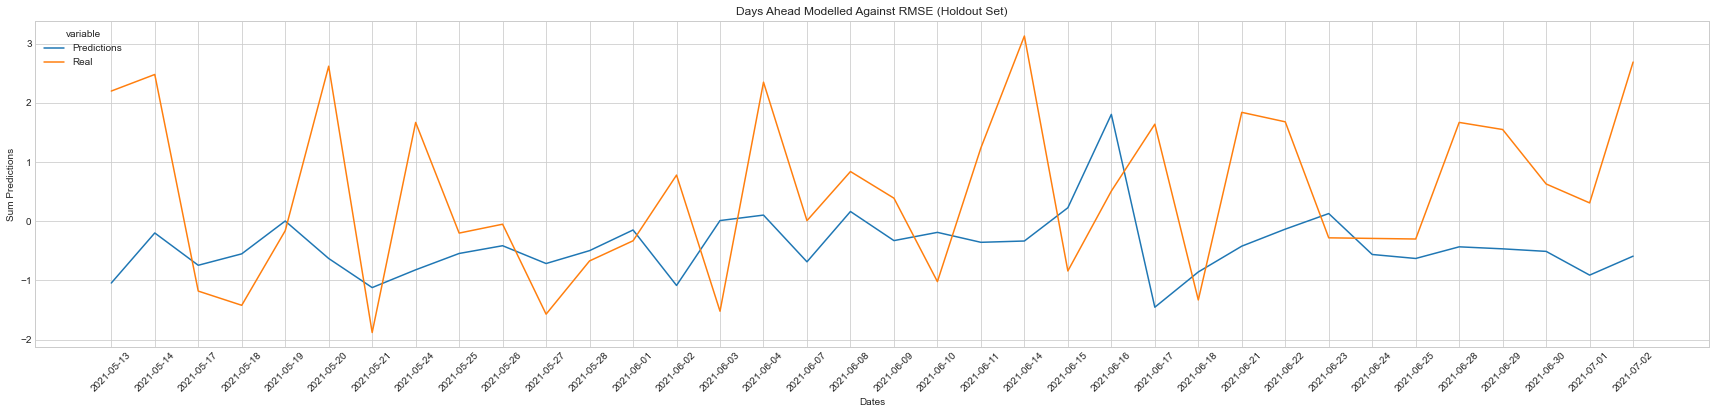

In [14]:
predsuml = [item for sublist in predsumlist for item in sublist]
realal = [item for sublist in realalist for item in sublist]

diction = {"Predictions": predsuml, "Real": realal, "Dates": unique}
dfsea = pd.DataFrame(diction) 
dfsea = dfsea.sort_values(by=['Dates'])
plt.style.use('seaborn-whitegrid')

# sortedlist = np.sort(unique)
# sortedlist = sortedlist[0::19]

fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Dates',y='value',hue='variable',ax=ax, data = pd.melt(dfsea,["Dates"]))
ax.set(xlabel='Dates',ylabel='Sum Predictions',title='Days Ahead Modelled Against RMSE (Holdout Set)')
plt.xticks(rotation=45)

In [3]:
merged = pd.read_csv('mergedfullholdout.csv')
merged = merged.dropna(subset=['Change1','Change2','Change3','Change4','Change5'])
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer
# https://python.gotrained.com/scraping-tweets-sentiment-analysis/
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    
    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))
    # Replace all emojis with text
    processed_tweet = emoji.demojize(processed_tweet)
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    # Remove single characters from the start
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    processed_tweet = lemming(processed_tweet)
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)
x_holdout = processed_tweets

In [5]:
y_holdout = merged[['Change','Change1','Change2','Change3','Change4','Change5']]
y_holdout_dates = merged[['usedate','usedate1','usedate2','usedate3','usedate4','usedate5']]

In [4]:
# with open("x_holdout.txt", "wb") as fp:   #Pickling
#     pickle.dump(x_holdout, fp)
# with open("y_holdout.txt", "wb") as fp:   #Pickling
#     pickle.dump(y_holdout, fp)
# with open("y_holdout_dates.txt", "wb") as fp:   #Pickling
#     pickle.dump(y_holdout_dates, fp)

with open("x_holdout.txt", "rb") as fp:   # Unpickling
    x_holdout = pickle.load(fp)
with open("y_holdout.txt", "rb") as fp:   # Unpickling
    y_holdout = pickle.load(fp)
with open("y_holdout_dates.txt", "rb") as fp:   # Unpickling
    y_holdout_dates = pickle.load(fp)

In [3]:

# y_holdout = y_holdout.values.reshape(-1,1)
# y_holdout = y_holdout.astype(np.float32)

In [11]:
y_holdout_dates

,usedate,usedate1,usedate2,usedate3,usedate4,usedate5
35674,2021-07-01,2021-07-02,2021-07-06,2021-07-07,2021-07-08,2021-07-09
35675,2021-07-01,2021-07-02,2021-07-06,2021-07-07,2021-07-08,2021-07-09
35676,2021-07-01,2021-07-02,2021-07-06,2021-07-07,2021-07-08,2021-07-09
35677,2021-07-01,2021-07-02,2021-07-06,2021-07-07,2021-07-08,2021-07-09
35678,2021-07-01,2021-07-02,2021-07-06,2021-07-07,2021-07-08,2021-07-09
...,...,...,...,...,...,...
448141,2021-05-12,2021-05-13,2021-05-14,2021-05-17,2021-05-18,2021-05-19
448142,2021-05-12,2021-05-13,2021-05-14,2021-05-17,2021-05-18,2021-05-19
448143,2021-05-12,2021-05-13,2021-05-14,2021-05-17,2021-05-18,2021-05-19
448144,2021-05-12,2021-05-13,2021-05-14,2021-05-17,2021-05-18,2021-05-19


In [9]:
y_pred_holdout= pipe.predict(x_holdout)
rmse = mean_squared_error(y_holdout['Change2'], y_pred_holdout, squared = False)
print("RMSE:", rmse)

RMSE: 1.470029897427177


In [12]:
modelpreds = y_pred_holdout
y = y_holdout['Change2']
z = y_holdout_dates['usedate2']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:
    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [-65.349266]
Accuracy: 0.4444444444444444
Sum Invested: [147.59924]
Profitability: [-0.44274798]


In [8]:
predsuml = [item for sublist in predsumlist for item in sublist]
realal = [item for sublist in realalist for item in sublist]

In [17]:
print(len(unique))
sortedlist = np.sort(unique)
sortedlist = sortedlist[0::19]
print(sortedlist)
print(min(unique))
print(max(unique))

247
['2020-05-13' '2020-06-10' '2020-07-08' '2020-08-04' '2020-08-31'
 '2020-09-28' '2020-10-23' '2020-11-19' '2020-12-17' '2021-01-15'
 '2021-02-12' '2021-03-12' '2021-04-09']
2020-05-13
2021-05-05


([<matplotlib.axis.XTick at 0x1f49a568910>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

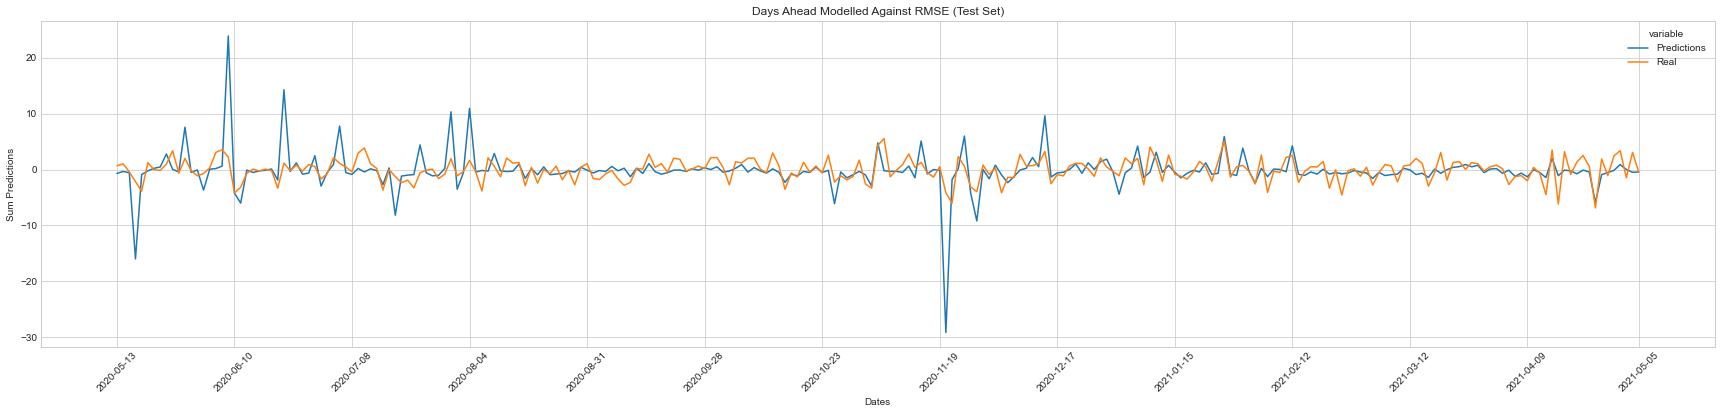

In [19]:
diction = {"Predictions": predsuml, "Real": realal, "Dates": unique}
dfsea = pd.DataFrame(diction) 
dfsea = dfsea.sort_values(by=['Dates'])
plt.style.use('seaborn-whitegrid')

fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Dates',y='value',hue='variable',ax=ax, data = pd.melt(dfsea,["Dates"]))
ax.set(xlabel='Dates',ylabel='Sum Predictions',title='Days Ahead Modelled Against RMSE (Test Set)')
plt.xticks(['2020-05-13','2020-06-10', '2020-07-08', '2020-08-04', '2020-08-31',
 '2020-09-28', '2020-10-23', '2020-11-19', '2020-12-17', '2021-01-15',
 '2021-02-12', '2021-03-12', '2021-04-09','2021-05-05'],rotation=45)

In [15]:
diction = {"Predictions": predsuml, "Real": realal, "Dates": unique}
dfsea = pd.DataFrame(diction) 
dfsea = dfsea.sort_values(by=['Dates'])
plt.style.use('seaborn-whitegrid')

([<matplotlib.axis.XTick at 0x164b8144430>,
 [Text(0, 0, ''), Text(0, 0, '')])

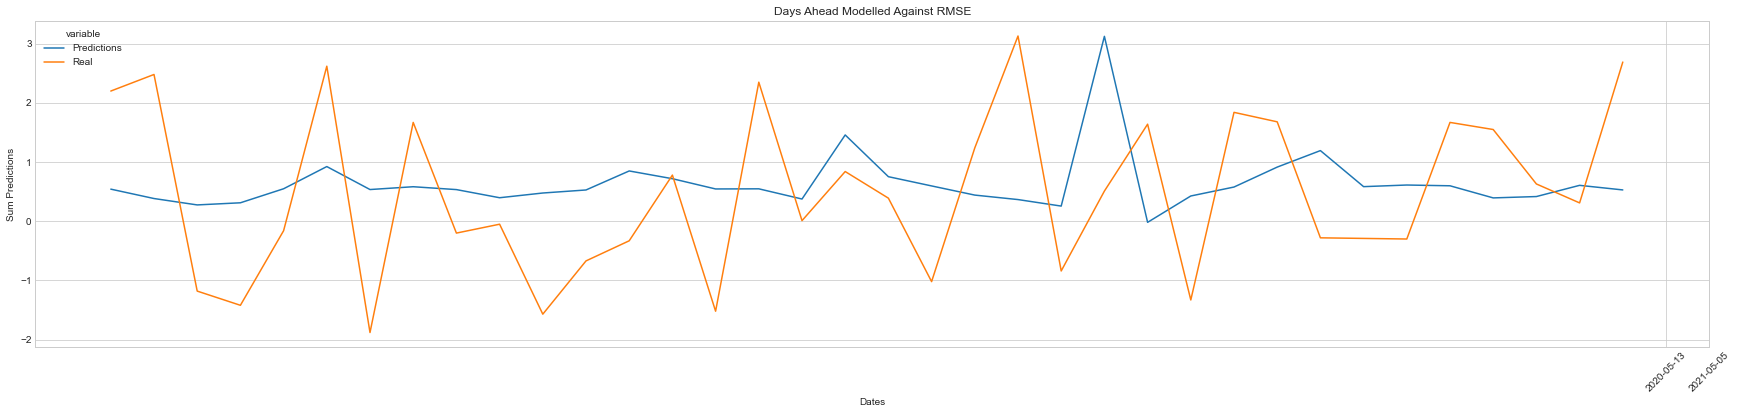

In [16]:
fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Dates',y='value',hue='variable',ax=ax, data = pd.melt(dfsea,["Dates"]))
ax.set(xlabel='Dates',ylabel='Sum Predictions',title='Days Ahead Modelled Against RMSE (Holdout Set)')
plt.xticks(['2021-05-12','2021-07-09'],rotation=45)

In [41]:
predsumlabs = [abs(number) for number in predsuml]
realalabs = [abs(number) for number in realal]
print(sum(predsumlabs)/len(predsumlabs))
print(sum(realalabs)/len(realalabs))
print((sum(realalabs)/len(realalabs))/(sum(predsumlabs)/len(predsumlabs)))

0.10486829351374091
1.5493008067175325
14.77377722861989
